In [1]:
import numpy as np
import pylab as pb
import GPy

pb.ion()

In [2]:
# Edit this line to access a different backup file
backup_index = 4249

X = np.load("hc_baby.npy", allow_pickle=True)
Y = np.log(np.load("samples_baby.npy", allow_pickle=True))

In [3]:
X_raw = np.load("hc_demo3.npy", allow_pickle=True)
Y_raw = np.log(np.load("samples_backup_i" + str(backup_index) + ".npy",
    allow_pickle=True))

 /tmp/ipykernel_297716/699833149.py:2: RuntimeWarning:divide by zero encountered in log


In [4]:
# We have to truncate the matrices a little because they use the shapes of the
# final products, meaning a lot of unfilled cells
X_truncated = X_raw[:backup_index]
Y_truncated = Y_raw[:backup_index]
# Possible off-by-one error here, but in this case that just means we're
# excluding one sample.

In [5]:
scale_factor = np.load("standard_k.npy", allow_pickle=True)

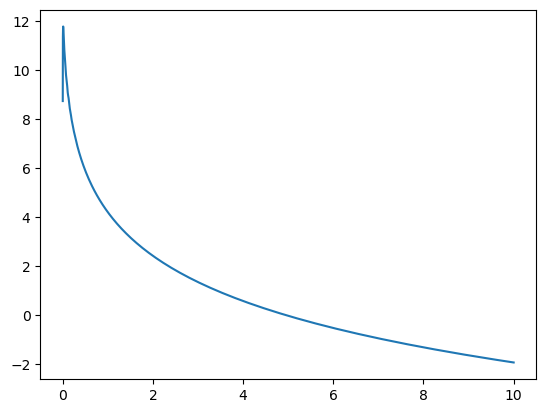

In [6]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scale_factor, Y_truncated[0])

In [7]:
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if float('-inf') in pspec:
        print("-inf")
    if float('inf') in pspec:
        print("inf")
    if None in pspec:
        print("None")
    if True in np.isnan(pspec):
        print("NaN in row", i)
        print(X_truncated[i])
    if 0 in pspec:
        print("zero")

NaN in row 35
[2.45107500e-02 6.89625000e-02 8.68730000e-01 8.60080000e-01
 9.67100000e-03 2.40950106e-09]
NaN in row 112
[2.50927500e-02 8.71665000e-02 9.98938000e-01 7.66160000e-01
 7.09100000e-03 1.09467063e-09]
NaN in row 124
[2.5874250e-02 6.2402500e-02 8.7294200e-01 9.4664000e-01 1.5300000e-04
 1.1246248e-09]
NaN in row 125
[2.40757500e-02 8.15495000e-02 1.06705800e+00 8.54480000e-01
 7.43900000e-03 1.14433149e-09]
NaN in row 306
[2.36422500e-02 5.69905000e-02 1.01620200e+00 8.55920000e-01
 2.07700000e-03 1.45254414e-09]
NaN in row 320
[2.12677500e-02 5.87945000e-02 1.00164200e+00 8.76880000e-01
 9.26900000e-03 1.59443232e-09]
NaN in row 398
[2.29417500e-02 5.10865000e-02 9.45690000e-01 9.00400000e-01
 9.98700000e-03 2.07212251e-09]
NaN in row 498
[2.11057500e-02 5.03485000e-02 8.75386000e-01 8.82960000e-01
 5.37700000e-03 1.46515642e-09]
NaN in row 517
[2.56117500e-02 6.67075000e-02 8.47098000e-01 8.50000000e-01
 5.41500000e-03 1.22473479e-09]
NaN in row 526
[2.51107500e-02 9.33

In [8]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_truncated, bad_row_indices, 0)
Y = np.delete(Y_truncated, bad_row_indices, 0)

'''
# Now remove the offending rows
for i in reversed(bad_row_indices):
    # iterate backwards or else concurrent modification
    # makes the indices meaningless
    X.pop(i)
    Y.pop(i)
'''

'\n# Now remove the offending rows\nfor i in reversed(bad_row_indices):\n    # iterate backwards or else concurrent modification\n    # makes the indices meaningless\n    X.pop(i)\n    Y.pop(i)\n'

In [9]:
print(X.shape, Y.shape)

(4183, 6) (4183, 300)


In [10]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

In [11]:
m.constrain_positive('') # '' is a regex matching all parameter names
m.optimize()

 /home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


In [12]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, 2.12723788013000E-09
])])
x

array([[2.24450000e-02, 1.20567000e-01, 9.60000000e-01, 8.24667740e-01,
        0.00000000e+00, 2.12723788e-09]])

In [13]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale factor k')

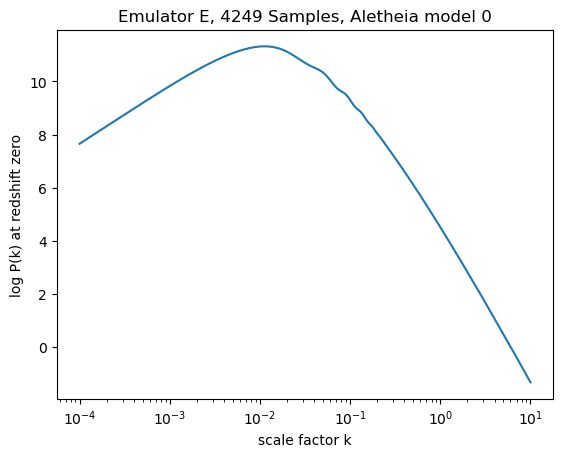

In [14]:
#import matplotlib.pyplot as plt
pb.plot(scale_factor, guess[0])
pb.title("Emulator E, 4249 Samples, Aletheia model 0")
pb.xscale('log')
pb.ylabel('log P(k) at redshift zero')
pb.xlabel('scale factor k')

In [15]:
# Now let's check our work with battery
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

# Compare like to like
massless_cosmology = spectra.specify_neutrino_mass(spectra.cosm.iloc[0], 0, 0)
k_m0truth, z_m0truth, p_m0truth, s_m0truth = \
    spectra.kzps(massless_cosmology, zs=[0], k_points=300)
print(s_m0truth)

[0.82466774]


Next steps:
* Import "ground truth": what the plot was really supposed to look like for model 0
* Play with omega_nu, n_s, omega_nu + omega_cdm to see if you can get the same behavior as in the animations

Text(0.5, 0, 'scale factor k')

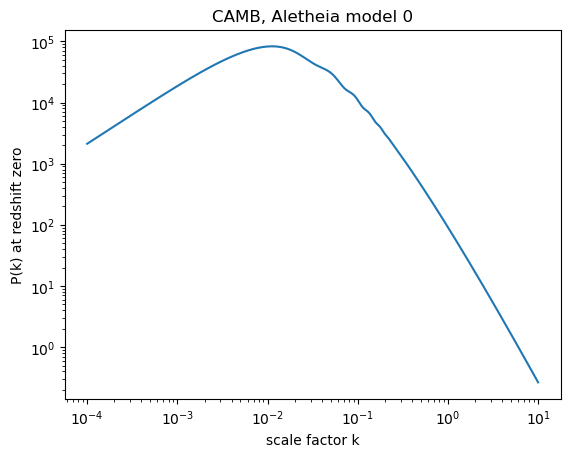

In [16]:
#import matplotlib.pyplot as plt
pb.loglog(k_m0truth, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale factor k')

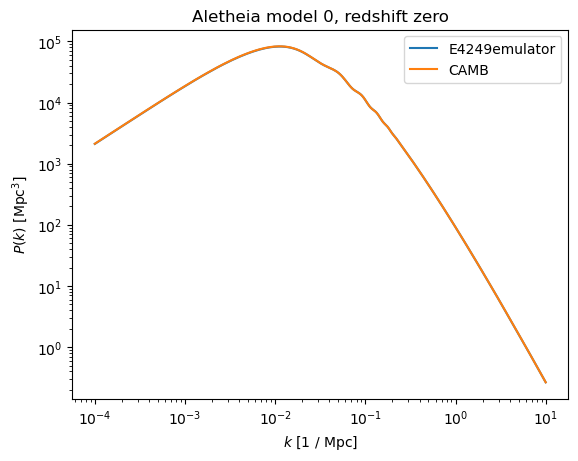

In [17]:
pb.plot(scale_factor, np.exp(guess[0]), label="E" + str(backup_index) + "emulator")
pb.loglog(k_m0truth, p_m0truth, label="CAMB")
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('$k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, '$k$ [1 / Mpc]')

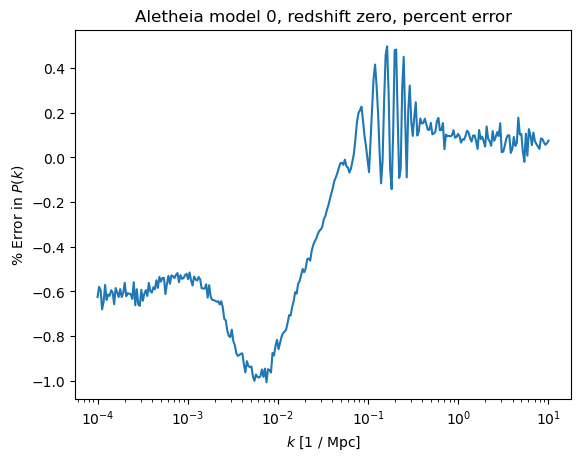

In [30]:
pb.plot(scale_factor, (np.exp(guess[0]) - p_m0truth) / p_m0truth * 100)
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('$k$ [1 / Mpc]')

Pretty bad, even for such an early iteration. Routes for improvement:

* This is about 800 samples short of the full 5000 we intended to use.

* There are still wasted cells (for which h modification fails to suffice). These nominally only represent about 80-90 cells, but their absence could potentially bias the emulator's performance.

* This particular case would benefit strongly from a separate $\omega_\nu = 0$ emulator

* I think Andrea had some ideas for optimizing the GP performance simply by changing the GP setup.

In [18]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.1, 0.82466774, 0, 2.12723788013000E-09
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.84, 0.82466774, 0, 2.12723788013000E-09
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


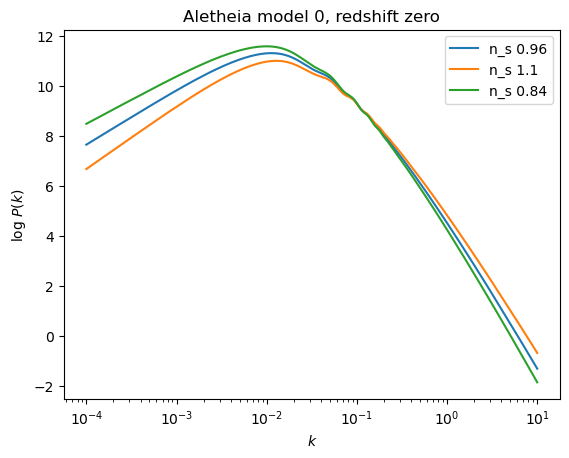

In [19]:
pb.plot(scale_factor, guess[0], label="n_s 0.96")
pb.plot(scale_factor, guess_hi_ns[0], label="n_s 1.1")
pb.plot(scale_factor, guess_lo_ns[0], label="n_s 0.84")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [20]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774, omnu_hi,\
    2.12723788013000E-09
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(x_hi_omnu)

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774, omnu_mid, \
    2.12723788013000E-09
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(x_mid_omnu)


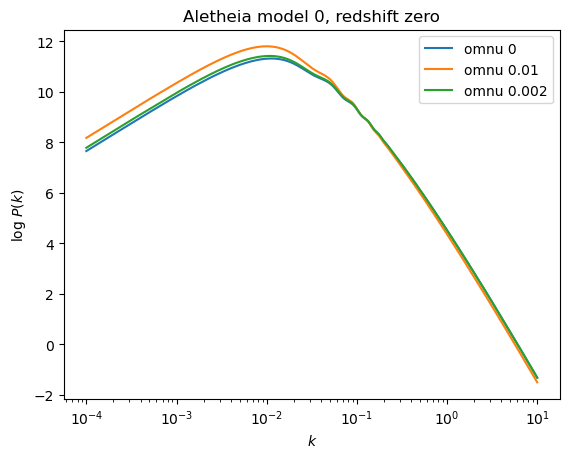

In [21]:
pb.plot(scale_factor, guess[0], label="omnu 0")
pb.plot(scale_factor, guess_hi_omnu[0], label="omnu 0.01")
pb.plot(scale_factor, guess_mid_omnu[0], label="omnu 0.002")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [22]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
hi_factor = 1.15
x_hi_omm = np.array([np.array([
    0.022445 * hi_factor, 0.120567 * hi_factor, 0.96, 0.82466774, 0,\
    2.12723788013000E-09
])])
guess_hi_omm, uncertainties_hi_omm = m.predict(x_hi_omm)

lo_factor = 0.85
x_lo_omm = np.array([np.array([
    0.022445 * lo_factor, 0.120567 * lo_factor, 0.96, 0.82466774, 0, \
    2.12723788013000E-09
])])
guess_lo_omm, uncertainties_lo_omm = m.predict(x_lo_omm)


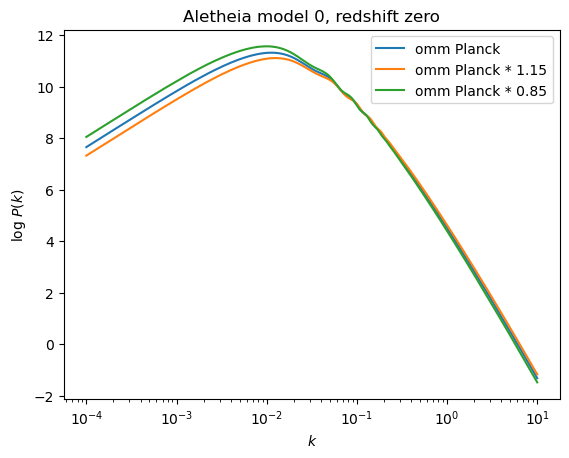

In [23]:
pb.plot(scale_factor, guess[0], label="omm Planck")
pb.plot(scale_factor, guess_hi_omm[0], label="omm Planck * 1.15")
pb.plot(scale_factor, guess_lo_omm[0], label="omm Planck * 0.85")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [24]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(3.91) / 10 ** 10
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(2.35) / 10 ** 10 
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

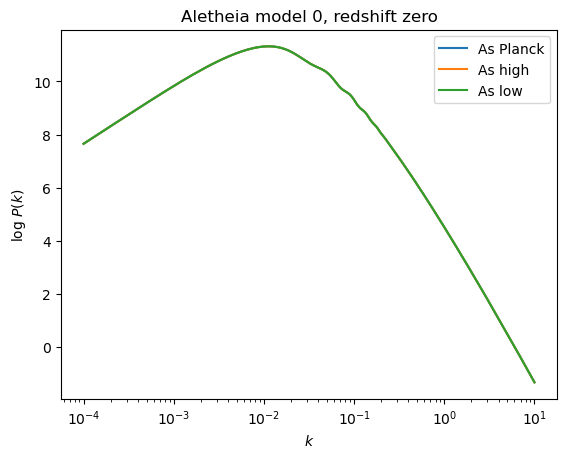

In [25]:
pb.plot(scale_factor, guess[0], label="As Planck")
pb.plot(scale_factor, guess_hi_As[0], label="As high")
pb.plot(scale_factor, guess_lo_As[0], label="As low")

pb.xscale('log')

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

I guess this shows that sigma12 countermands As, huh?